<a href="https://colab.research.google.com/github/jkierzkowski/ML/blob/main/ProjektUM_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Walmart sales predictions**
The objective of this project is to provide product recommendations based on historical transaction data and additional customer and product metadata.
**source:**
https://www.kaggle.com/competitions/walmart-recruiting-store-sales-forecasting/overview

**Provided data:**
You are provided with historical sales data for 45 Walmart stores located in different regions. Each store contains a number of departments, and you are tasked with predicting the department-wide sales for each store.

In addition, Walmart runs several promotional markdown events throughout the year. These markdowns precede prominent holidays, the four largest of which are the Super Bowl, Labor Day, Thanksgiving, and Christmas. The weeks including these holidays are weighted five times higher in the evaluation than non-holiday weeks. Part of the challenge presented by this competition is modeling the effects of markdowns on these holiday weeks in the absence of complete/ideal historical data.

There are 5 csv files:

**Data location**: https://www.kaggle.com/competitions/walmart-recruiting-store-sales-forecasting/data

**Type of model:**



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
#!pip install tensorflow_decision_forests
#import tensorflow_decision_forests as tfdf
import importlib
from datetime import datetime


In [ ]:

!mkdir data

#dowloading data
!gdown 'https://drive.google.com/file/d/1rwMNMfKhye9Wm6I0qVxxj5lNRyBtWf_N/view?usp=sharing' -O /content/data/walmart-recruiting-store-sales-forecasting.zip --no-check-certificate --fuzzy
%cd /content/data

#unziping files
!unzip walmart-recruiting-store-sales-forecasting
!unzip features.csv
!unzip sampleSubmission.csv
!unzip test.csv
!unzip train.csv
#cleaning zip files

!rm walmart-recruiting-store-sales-forecasting.zip
!rm features.csv.zip
!rm sampleSubmission.csv.zip
!rm test.csv.zip
!rm train.csv.zip

%cd ..

/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'drive.google.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doc-0g-8s-docs.googleusercontent.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1rwMNMfKhye9Wm6I0qVxxj5lNRyBtWf_N
To: /content/data/walmart-recruiting-store-sales-forecasting.zip
100% 2.83M/2.83M [00:00<00:00, 22.9MB/s]
/content/data
Archive:  walmart-recruiting-store-sales-forecasting.zip
  inflating: features.csv.zip        
  inflating: sampleSubmission.csv.zip  
  inflating: st

In [ ]:
#Loading CSV files
%time
features_dataFile = pd.read_csv('data/features.csv')
stores_dataFile = pd.read_csv('data/stores.csv')
sample_sub_dataFile = pd.read_csv('data/sampleSubmission.csv')
test_dataFile = pd.read_csv('data/test.csv')
train_dataFile = pd.read_csv('data/train.csv')

CPU times: user 1 µs, sys: 1e+03 ns, total: 2 µs
Wall time: 4.29 µs


#Printing first and last rows of raw data from files given by Walmart
print(f"Features columns:\n{features_dataFile.head(-5)}\n-------------------------------------------------------------------------")

print(f"Stores columns:\n{stores_dataFile.head(-5)}\n-------------------------------------------------------------------------")

print(f"Test columns:\n{test_dataFile.head(-5)}\n-------------------------------------------------------------------------")

print(f"Train columns:\n{train_dataFile.head(-5)}\n-------------------------------------------------------------------------")

print(f"Sample submission columns:\n{sample_sub_dataFile.head(5)}\n-------------------------------------------------------------------------")

In [ ]:
features_n_stores = features_dataFile.merge(stores_dataFile, how='inner', on='Store')
print(features_n_stores.Date.head(2))
print(train_dataFile.Date.head(2))
print(test_dataFile.Date.head(2),'\n----------------------------------')

#converting dates to date type
features_n_stores.Date = pd.to_datetime(features_n_stores.Date)
train_dataFile.Date = pd.to_datetime(train_dataFile.Date)
test_dataFile.Date = pd.to_datetime(test_dataFile.Date)

#testing results
print(features_n_stores.Date.head(2))
print(train_dataFile.Date.head(2))
print(test_dataFile.Date.head(2))


0    2010-02-05
1    2010-02-12
Name: Date, dtype: object
0    2010-02-05
1    2010-02-12
Name: Date, dtype: object
0    2012-11-02
1    2012-11-09
Name: Date, dtype: object 
----------------------------------
0   2010-02-05
1   2010-02-12
Name: Date, dtype: datetime64[ns]
0   2010-02-05
1   2010-02-12
Name: Date, dtype: datetime64[ns]
0   2012-11-02
1   2012-11-09
Name: Date, dtype: datetime64[ns]


In [ ]:
#Creating training and test datasets
features_n_stores['Week'] = features_n_stores.Date.dt.isocalendar().week
train_detail = train_dataFile.merge(features_n_stores,
                           how='inner',
                           on=['Store','Date','IsHoliday']).sort_values(by=['Store',
                                                                            'Dept',
                                                                            'Date']).reset_index(drop=True)

test_detail = test_dataFile.merge(features_n_stores,
                           how='inner',
                           on=['Store','Date','IsHoliday']).sort_values(by=['Store',
                                                                            'Dept',
                                                                            'Date']).reset_index(drop=True)

train_detail.loc[(train_detail.Date.dt.year==2010) & (train_detail.Week==13), 'IsHoliday'] = True
train_detail.loc[(train_detail.Date.dt.year==2011) & (train_detail.Week==16), 'IsHoliday'] = True
train_detail.loc[(train_detail.Date.dt.year==2012) & (train_detail.Week==14), 'IsHoliday'] = True
test_detail.loc[(test_detail.Date.dt.year==2013) & (test_detail.Week==13), 'IsHoliday'] = True

#spliting dates into 3 columns - year month day
train_detail['year'] = train_detail.Date.dt.year
train_detail['month'] = train_detail.Date.dt.month
train_detail['day'] = train_detail.Date.dt.day
train_detail['week'] = train_detail['Week'].astype(int)

test_detail['year'] = test_detail.Date.dt.year
test_detail['month'] = test_detail.Date.dt.month
test_detail['day'] = test_detail.Date.dt.day
test_detail['week'] = test_detail['Week'].astype(int)

#Filling up the missing data
train_detail['MarkDown1'].fillna(0, inplace=True)
train_detail['MarkDown2'].fillna(0, inplace=True)
train_detail['MarkDown3'].fillna(0, inplace=True)
train_detail['MarkDown4'].fillna(0, inplace=True)
train_detail['MarkDown5'].fillna(0, inplace=True)

print("TRAIN DATA")
print(train_detail.head(-20))
print('\n\n----------------------------0      1     1  2010-02-05      24924.50      False-------------------------------------------\nTEST DATA')
print(test_detail.head(-20))


TRAIN DATA
        Store  Dept       Date  Weekly_Sales  IsHoliday  Temperature  \
0           1     1 2010-02-05      24924.50      False        42.31   
1           1     1 2010-02-12      46039.49       True        38.51   
2           1     1 2010-02-19      41595.55      False        39.93   
3           1     1 2010-02-26      19403.54      False        46.63   
4           1     1 2010-03-05      21827.90      False        46.50   
...       ...   ...        ...           ...        ...          ...   
421545     45    98 2012-05-11        893.60      False        61.24   
421546     45    98 2012-05-18        745.44      False        66.30   
421547     45    98 2012-05-25        795.94      False        67.21   
421548     45    98 2012-06-01        874.64      False        74.48   
421549     45    98 2012-06-08        713.50      False        64.30   

        Fuel_Price  MarkDown1  MarkDown2  MarkDown3  ...  MarkDown5  \
0            2.572       0.00        0.0       0.00  

/tmp/ipython-input-3732697879.py:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_detail['MarkDown1'].fillna(0, inplace=True)
/tmp/ipython-input-3732697879.py:33: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try

693099.36 -4988.94


(array([ 34388., 142460.,  68474.,  43324.,  30859.,  20460.,  15055.,
         12378.,   9868.,   7808.,   6453.,   5276.,   4467.,   3430.,
          2979.,   2543.,   2036.,   1634.,   1228.,   1028.,    792.,
           703.,    629.,    475.,    343.,    306.,    291.,    252.,
           251.,    233.]),
 array([ -4988.94 ,    177.358,   5343.656,  10509.954,  15676.252,
         20842.55 ,  26008.848,  31175.146,  36341.444,  41507.742,
         46674.04 ,  51840.338,  57006.636,  62172.934,  67339.232,
         72505.53 ,  77671.828,  82838.126,  88004.424,  93170.722,
         98337.02 , 103503.318, 108669.616, 113835.914, 119002.212,
        124168.51 , 129334.808, 134501.106, 139667.404, 144833.702,
        150000.   ]),
 <BarContainer object of 30 artists>)

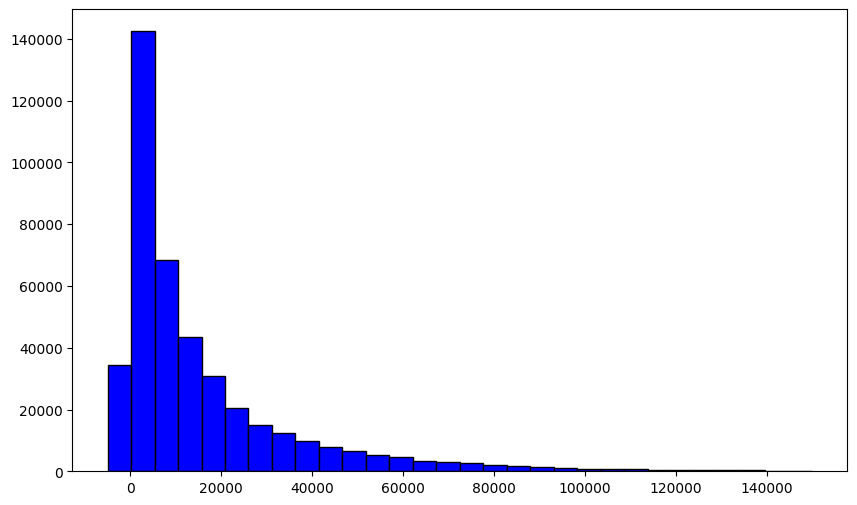

In [ ]:
import matplotlib.pyplot as plt
min_val = train_detail['Weekly_Sales'].min()
max_val = train_detail['Weekly_Sales'].max()
print(max_val,min_val)
plt.figure(figsize=(10, 6))
plt.hist(train_detail['Weekly_Sales'], bins=30, color='blue', edgecolor='black',range=(min_val, 150_000))

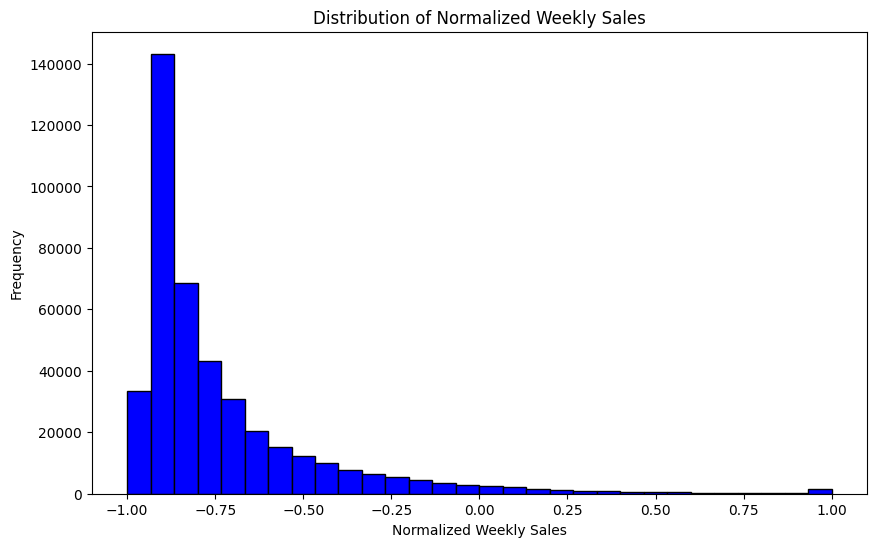

In [ ]:
#normalization of weekly sales coluumn
def normalize_column(df, column_name,col_min,col_max):
    norm_val = 2 * ((df[column_name] - col_min) / (col_max - col_min)) - 1
    norm_val[norm_val>1] = 1
    norm_val[norm_val<-1] = -1
    df[column_name + '_normalized'] = norm_val

# Normalize the 'Weekly_Sales' column max and min values are estimated
# from histogram above
col_max = 150_000
col_min = -5_000
normalize_column(train_detail, 'Weekly_Sales',col_min,col_max)


plt.figure(figsize=(10, 6))
plt.hist(train_detail['Weekly_Sales_normalized'], bins=30, color='blue', edgecolor='black',range=(-1,1))
plt.title('Distribution of Normalized Weekly Sales')
plt.xlabel('Normalized Weekly Sales')
plt.ylabel('Frequency')
plt.show()

In [ ]:
print(train_detail['Weekly_Sales_normalized'].max())
print(train_detail['Weekly_Sales_normalized'].min())

1.0
-0.9998572903225806


In [ ]:
#checking for missing data
print(np.sum(pd.isna(train_detail)))

Store                      0
Dept                       0
Date                       0
Weekly_Sales               0
IsHoliday                  0
Temperature                0
Fuel_Price                 0
MarkDown1                  0
MarkDown2                  0
MarkDown3                  0
MarkDown4                  0
MarkDown5                  0
CPI                        0
Unemployment               0
Type                       0
Size                       0
Week                       0
year                       0
month                      0
day                        0
week                       0
Weekly_Sales_normalized    0
dtype: int64


/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


In [ ]:
print(train_detail.dtypes)

Store                               int64
Dept                                int64
Date                       datetime64[ns]
Weekly_Sales                      float64
IsHoliday                            bool
Temperature                       float64
Fuel_Price                        float64
MarkDown1                         float64
MarkDown2                         float64
MarkDown3                         float64
MarkDown4                         float64
MarkDown5                         float64
CPI                               float64
Unemployment                      float64
Type                               object
Size                                int64
Week                               UInt32
year                                int32
month                               int32
day                                 int32
week                                int64
Weekly_Sales_normalized           float64
dtype: object


Model will be evaluated based on WMAE(weigthed mean absolute error) so I define the weights. If IsHoliday equals to True then weight is 5 if not 1.

In [ ]:
#Weights definition
df_train_weights = np.ones_like(train_detail['IsHoliday'],dtype=int)
df_train_weights[train_detail['IsHoliday']] = 5
train_weights = tf.convert_to_tensor(df_train_weights)

df_test_weights = np.ones_like(test_detail['IsHoliday'],dtype=int)
df_test_weights[test_detail['IsHoliday']] = 5
test_weights = tf.convert_to_tensor(df_test_weights)

In [ ]:
#seprates features and labels
labels = tf.convert_to_tensor(train_detail["Weekly_Sales_normalized"])
features_names = ['Store', 'Dept', 'Temperature',
       'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4',
       'MarkDown5','year','day','month','week'
       ]
dt_features = train_detail[features_names]
features = tf.convert_to_tensor(dt_features)
train_DS = tf.data.Dataset.from_tensor_slices((features,labels,train_weights))

for f,l,w in train_DS.take(3):
  print("Features: ",f.numpy(),'shape: ', f.numpy().shape,"Labels: ",l.numpy(),'shape: ', l.numpy().shape,end=' ' )
  print("Weight = ",w.numpy())
test_DS = tf.data.Dataset.from_tensor_slices((tf.convert_to_tensor(test_detail[features_names]),test_weights))
print("================================================================================")
for t, w in test_DS.take(3):
  print('Test feature: ', t.numpy(),end=' ' )
  print('shape: ', t.numpy().shape,"Weight = ",w.numpy())


Features:  [1.000e+00 1.000e+00 4.231e+01 2.572e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 2.010e+03 5.000e+00 2.000e+00 5.000e+00] shape:  (13,) Labels:  -0.6138774193548386 shape:  () Weight =  1
Features:  [1.000e+00 1.000e+00 3.851e+01 2.548e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 2.010e+03 1.200e+01 2.000e+00 6.000e+00] shape:  (13,) Labels:  -0.341425935483871 shape:  () Weight =  5
Features:  [1.000e+00 1.000e+00 3.993e+01 2.514e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 2.010e+03 1.900e+01 2.000e+00 7.000e+00] shape:  (13,) Labels:  -0.39876709677419353 shape:  () Weight =  1
Test feature:  [1.00000e+00 1.00000e+00 5.53200e+01 3.38600e+00 6.76644e+03 5.14770e+03
 5.08200e+01 3.63990e+03 2.73742e+03 2.01200e+03 2.00000e+00 1.10000e+01
 4.40000e+01] shape:  (13,) Weight =  1
Test feature:  [1.000000e+00 1.000000e+00 6.124000e+01 3.314000e+00 1.142132e+04
 3.370890e+03 4.028000e+01 4.646790e+03 6.154160e+03 2.012000e+03
 9.000000e+00 1.100000

In [ ]:

#Shuffling dataset
#train_DS = train_DS.shuffle(buffer_size=10_000).cache()
#Batching training data
batchSize = 256
train_DS = train_DS.batch(batchSize).cache()


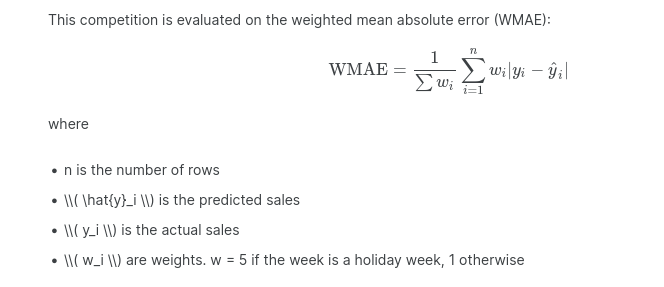

In [ ]:
!gdown 'https://drive.google.com/file/d/1jCTHMNc0ZMJXeRVpu6h7mb3nIz23u4yD/view?usp=drive_link' -O /content/model_func.py --no-check-certificate --fuzzy

/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'drive.google.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'drive.google.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doc-04-1g-docs.googleusercontent.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
Downloading...
From (original): https://driv

In [ ]:
import model_func as mf
importlib.reload(mf)

<module 'model_func' from '/content/model_func.py'>

In [ ]:
#Class below is taken from tf documentation, purely to execute WMAE loss function
#https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit
#Supporting sample_weight & class_weight
class CustomModel(tf.keras.Model):
    def train_step(self, data):
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `fit()`.
        if len(data) == 3:
            x, y, sample_weight = data
        else:
            sample_weight = None
            x, y = data

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass
            # Compute the loss value.
            # The loss function is configured in `compile()`.
            loss = self.compute_loss(
                y=y,
                y_pred=y_pred,
                sample_weight=sample_weight,
            )

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics.
        # Metrics are configured in `compile()`.
        for metric in self.metrics:
            if metric.name == "loss":
                metric.update_state(loss)
            else:
                metric.update_state(y, y_pred, sample_weight=sample_weight)

        # Return a dict mapping metric names to current value.
        # Note that it will include the loss (tracked in self.metrics).
        return {m.name: m.result() for m in self.metrics}


In [ ]:
#Decision random forest model
#model = tfdf.keras.RandomForestModel()
#check for nans
'''
def check_for_nans(dataset):
  for f, l in dataset:
    if tf.reduce_any(tf.math.is_nan(f)):
      print(f"NaNs found in feature column: {f}")
    if tf.reduce_any(tf.math.is_nan(l)):
      print("NaNs found in label column")
'''
# Check for NaNs in the training and testing datasets
#print("Checking training dataset for NaNs...")
#check_for_nans(train_DS.unbatch())
# Train the model
#model.fit(train_DS)

'\ndef check_for_nans(dataset):\n  for f, l in dataset:\n    if tf.reduce_any(tf.math.is_nan(f)):\n      print(f"NaNs found in feature column: {f}")\n    if tf.reduce_any(tf.math.is_nan(l)):\n      print("NaNs found in label column")\n'

In [ ]:
#learning rate scheduler
train_dat_size = labels.numpy().shape[0]
steps_per_epoch = int(train_dat_size/batchSize)
initial_learning_rate = 1e-3
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate,
                decay_steps=20*steps_per_epoch,
                decay_rate=0.95,
                staircase=True)

inputShape = (13,)
DenseLayersShape = [32,128,256,256,256,256,256]

inputs = tf.keras.Input(shape=inputShape, name="rf_features")
x = inputs
for i,L in enumerate(DenseLayersShape):
  x = tf.keras.layers.Dense(L, activation='relu',
                                  kernel_initializer="HeNormal",
                                  bias_initializer=tf.keras.initializers.RandomUniform(minval=-1, maxval=1),
                                  name="layer_"+str(i),
                                  kernel_regularizer=tf.keras.regularizers.L2(l2=0.01))(x)
  '''if i%2 == 0 and L>=512:
   x = tf.keras.layers.Dropout(0.04,name=f"DropOutLayer{i}")(x)
   '''
outputs = tf.keras.layers.Dense(1, activation='linear', name = "output")(x)
model = CustomModel(inputs,outputs)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss="mae", metrics=[],weighted_metrics=['mae'])
model.summary()


Model: "custom_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rf_features (InputLayer)        │ (None, 13)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_0 (Dense)                 │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_1 (Dense)                 │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_2 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_3 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_4 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_5 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_6 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 301,121 (1.15 MB)

 Trainable params: 301,121 (1.15 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
checkpoint_path = "/content/drive/MyDrive/UM_Project/CheckPoints/Checkpointsweights.weights.h5"
model.load_weights(checkpoint_path)
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 1 variables whereas the saved optimizer has 33 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "custom_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rf_features (InputLayer)        │ (None, 13)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_0 (Dense)                 │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_1 (Dense)                 │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_2 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_3 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_4 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_5 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_6 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 301,121 (1.15 MB)

 Trainable params: 301,121 (1.15 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
nEpochsSaved = 133
checkpoint_path = "/content/drive/MyDrive/UM_Project/CheckPoints/trained1500_Jun_15_2024_07_24.keras"
model = tf.keras.models.load_model(checkpoint_path.format(epoch=nEpochsSaved))
model.summary()

In [ ]:
saved_checkpoint_file_path = "/content/drive/MyDrive/UM_Project/CheckPoints/Checkpointsweights.weights.h5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                            filepath=saved_checkpoint_file_path,
                            save_weights_only=True,
                            monitor='val_loss',
                            mode='max',
                            verbose = 1)
nEpochs = 1500
init_epoch = 0
validation_skip = 400
ES_callback  = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                patience = 5,
                                                restore_best_weights=True,
                                                start_from_epoch = 20,
                                                verbose = 1)
history = model.fit(train_DS.skip(400), validation_data=train_DS.take(validation_skip),initial_epoch=init_epoch,
          epochs=nEpochs,callbacks=[ES_callback,model_checkpoint_callback],
          verbose=0)
from datetime import datetime
currentTime = datetime.now().strftime("%b_%d_%Y_%H_%M")
path = "/content/drive/MyDrive/UM_Project/CheckPoints/trained{epoch:04d}_"+currentTime+".keras"
model.save(path.format(epoch=nEpochs))


Epoch 1: saving model to /content/drive/MyDrive/UM_Project/CheckPoints/Checkpointsweights.weights.h5

Epoch 2: saving model to /content/drive/MyDrive/UM_Project/CheckPoints/Checkpointsweights.weights.h5

Epoch 3: saving model to /content/drive/MyDrive/UM_Project/CheckPoints/Checkpointsweights.weights.h5

Epoch 4: saving model to /content/drive/MyDrive/UM_Project/CheckPoints/Checkpointsweights.weights.h5

Epoch 5: saving model to /content/drive/MyDrive/UM_Project/CheckPoints/Checkpointsweights.weights.h5

Epoch 6: saving model to /content/drive/MyDrive/UM_Project/CheckPoints/Checkpointsweights.weights.h5

Epoch 7: saving model to /content/drive/MyDrive/UM_Project/CheckPoints/Checkpointsweights.weights.h5

Epoch 8: saving model to /content/drive/MyDrive/UM_Project/CheckPoints/Checkpointsweights.weights.h5

Epoch 9: saving model to /content/drive/MyDrive/UM_Project/CheckPoints/Checkpointsweights.weights.h5

Epoch 10: saving model to /content/drive/MyDrive/UM_Project/CheckPoints/Checkpoin

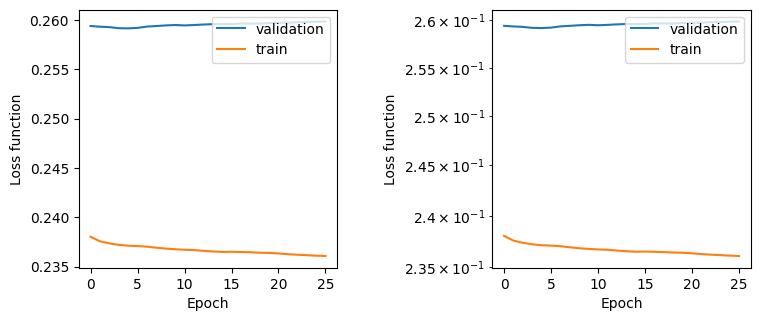

In [ ]:
mf.plotTrainHistory(history)

In [ ]:
print('Model evaluation validation data:')
model.evaluate(train_DS.take(validation_skip))
print('Model evaluation train data:')
model.evaluate(train_DS.skip(validation_skip))

Model evaluation validation data:
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2856 - mae: 0.2090
Model evaluation train data:
1247/1247 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.2610 - mae: 0.1911


[0.23529435694217682, 0.17230914533138275]